In [1]:
import pandas as pd
import tensorflow as tf

In [2]:
df = pd.read_csv("Dataset/MSFT.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061434,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063628,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064725,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.063079,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061982,47894400
...,...,...,...,...,...,...,...
9078,2022-03-18,295.369995,301.000000,292.730011,300.429993,300.429993,43317000
9079,2022-03-21,298.890015,300.140015,294.899994,299.160004,299.160004,28351200
9080,2022-03-22,299.799988,305.000000,298.769989,304.059998,304.059998,27599700
9081,2022-03-23,300.510010,303.230011,297.720001,299.489990,299.489990,25715400


In [3]:
df = df[['Date', 'Close']]
df

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9078,2022-03-18,300.429993
9079,2022-03-21,299.160004
9080,2022-03-22,304.059998
9081,2022-03-23,299.489990


In [4]:
df['Date']

0       1986-03-13
1       1986-03-14
2       1986-03-17
3       1986-03-18
4       1986-03-19
           ...    
9078    2022-03-18
9079    2022-03-21
9080    2022-03-22
9081    2022-03-23
9082    2022-03-24
Name: Date, Length: 9083, dtype: object

In [5]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [6]:
df

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9078,2022-03-18,300.429993
9079,2022-03-21,299.160004
9080,2022-03-22,304.059998
9081,2022-03-23,299.489990


In [7]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

C:\Users\ASHUTOSH\AppData\Local\Temp\ipykernel_5200\2565755782.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
9078   2022-03-18
9079   2022-03-21
9080   2022-03-22
9081   2022-03-23
9082   2022-03-24
Name: Date, Length: 9083, dtype: datetime64[ns]

In [8]:
df.index = df.pop('Date')
df

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2022-03-18,300.429993
2022-03-21,299.160004
2022-03-22,304.059998


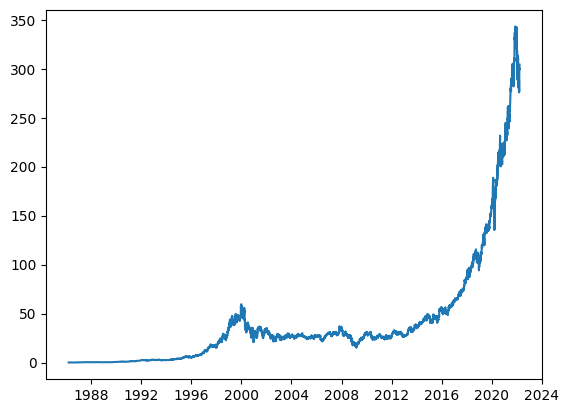

In [12]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])